In [7]:
# Gaussians python script:
import math
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum as fgc
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

# Script to perform multiple Gaussian fits on the double peak H-alpha line (on the blue, center and red peak)

file = np.loadtxt("0919_l12tdfawc.txt")
x = file[:,0]
y = file[:,1]

# x_new=[]
# y_new=[]

# for i in range(0,len(x)-1):
#     x_new.append(x[i])
#     x_new.append((x[i]+x[i+1])/2)
#     y_new.append(y[i])
#     y_new.append((y[i]+y[i+1])/2)
# print(len(x),len(x_new))

# fig=plt.figure(figsize=(16, 9)) #create the figure
# # plt.yscale("log") #set y scale to log to correctly display the spectra
# plt.xlim(6540,6550)
# plt.scatter(x, y, label='spectra',linewidth=4)
# plt.scatter(x_new, y_new, label='fitted continuum')
# plt.legend()
# plt.show()
# plt.close()

# x=x_new
# y=y_new

#Take the H_alpha subset of the data:
# x_data = x[(x>6520)&(x<6600)]
# y_data = y[(x>6520)&(x<6600)]



#plt.plot(x,y)
#plt.show()


def func_gaus(x, *params): #Fitting function gaussian
    y = np.zeros_like(x)
    
    # y=np.zeros(len(x)*2)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)**2/wid**2))
    return y+1

def func_lorentzian(x, *params): #Fitting function lorentzian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * (wid**2/((x-ctr)**2+wid**2))
    return y+1

def func_voigt(x, *params): #Fitting function voigt

    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        gam = wid-1
        y = y + voigt_profile(x - ctr, wid, gam) * amp
    return y+1

def find_double_peak_coords(x_data,y_data): #Function to find P_0 guess values for double peak plotting
    halpha_region_x = x_data[(x_data > 6540) & (x_data < 6590)]
    halpha_region_y = y_data[(x_data > 6540) & (x_data < 6590)]

    # print(halpha_region_x)

    peaks, props = find_peaks(halpha_region_y)
    # print(peaks)
    peak_wavelengths=halpha_region_x[peaks]
    peak_fluxes=halpha_region_y[peaks]
    if len(peaks)==2:
        valleys, props = find_peaks(-halpha_region_y)
        # print(valleys)
        valley_wavelength=halpha_region_x[valleys]
        valley_flux=halpha_region_y[valleys]
        # print(valley_wavelength,valley_flux)

        ctr1=math.trunc(peak_wavelengths[0]*10)
        amp1=math.trunc(peak_fluxes[0]*10)
        wid1=(1.0*(valley_wavelength-peak_wavelengths[0]))
        wid1=math.trunc(wid1[0]*0.6717699*10)
        wid1=7.95*10
        ctr2=valley_wavelength
        ctr2=math.trunc(ctr2[0]*10)
        wid2=0.5*((valley_wavelength-peak_wavelengths[0])+(peak_wavelengths[1]-valley_wavelength))
        wid2=math.trunc(wid2[0]*0.33588459*10)
        ctr3=math.trunc(peak_wavelengths[1]*10)
        amp3=math.trunc(peak_fluxes[1]*10)
        wid3=1.0*(peak_wavelengths[1]-valley_wavelength)
        wid3=math.trunc(wid3[0]*0.447849*10)
        wid3=7.95*10
        amp2=valley_flux
        # amp2=-((amp1/10+amp3/10)/2-amp2)*5
        amp2=math.trunc(amp2[0]*-0.76689539232*10)

        # result=[ctr1/10,amp1/10,wid1/10,ctr2/10,amp2/8,wid2/10,ctr3/10,amp3/10,wid3/10]
        result=[ctr1/10,amp1/10-1,wid1/10,ctr3/10,amp3/10-1,wid3/10]

    if len(peaks)==1:
        # print(peak_wavelengths[0])
        ctr1=math.trunc(peak_wavelengths[0]*10)
        amp1=math.trunc(peak_fluxes[0]*10)
        wid1=13.0*10

        result=[ctr1/10,amp1/10-1,wid1/10]
        print(result)

    return result


In [8]:
xmin,xmax = 6530-50,6590+50
graph_W,graph_H = 8,5

# x_new=[]
# y_new=[]

# for i in range(0,len(x)-1):
#     x_new.append(x[i])
#     x_new.append((x[i]+x[i+1])/2)
#     y_new.append(y[i])
#     y_new.append((y[i]+y[i+1])/2)
# print(len(x),len(x_new))

# fig=plt.figure(figsize=(16, 9)) #create the figure
# # plt.yscale("log") #set y scale to log to correctly display the spectra
# plt.xlim(6540,6550)
# plt.scatter(x, y, label='spectra',linewidth=4)
# plt.scatter(x_new, y_new, label='fitted continuum')
# plt.legend()
# plt.show()
# plt.close()

# x=x_new
# y=y_new

2048


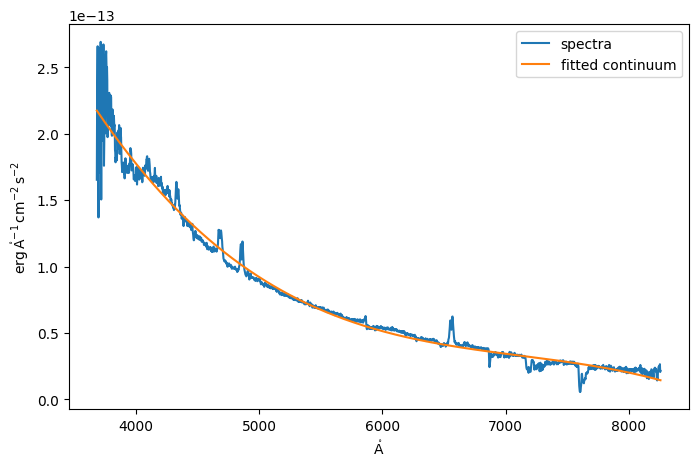

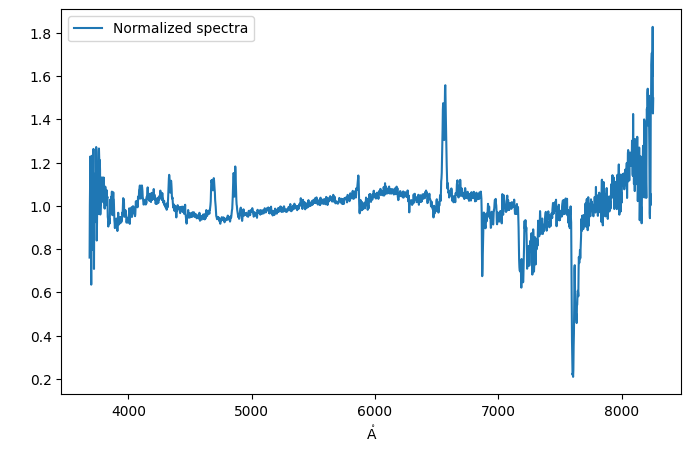

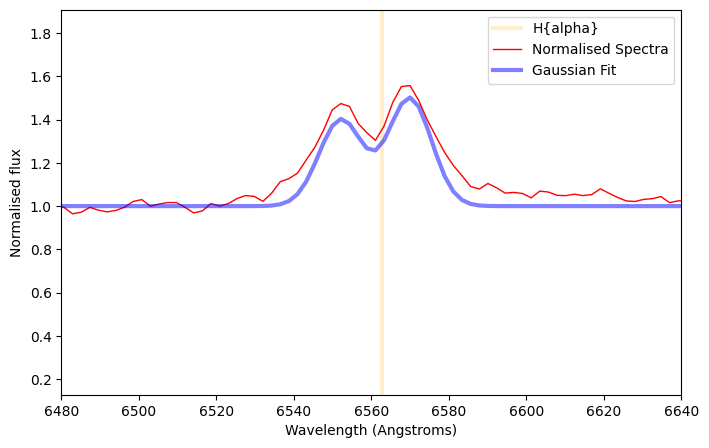

In [9]:

########### Function to normalise spectrum by dividing with fitted continuum (NTE this should only be done if imported data is not already normalised):
s1_cal=y*u.Unit('erg cm-2 s-2 AA-1') #flux data
wav_cal = x*u.AA #wavelength data

spec=Spectrum1D(spectral_axis=wav_cal,flux=s1_cal)
s_fit=fgc(spec,median_window=1)
y_cont_fitted=s_fit(wav_cal)
print(len(spec.spectral_axis.value))
# print(find_double_peak_coords(spec.spectral_axis.value,(spec.flux/y_cont_fitted).value))


fig=plt.figure(figsize=(graph_W,graph_H)) #create the figure
# plt.yscale("log") #set y scale to log to correctly display the spectra
plt.plot(spec.spectral_axis, spec.flux, label='spectra')
plt.plot(wav_cal, y_cont_fitted, label='fitted continuum')
plt.legend()
plt.show()
plt.close()

#now plot normalised spectra
fig=plt.figure(figsize=(graph_W,graph_H)) #create the figure

plt.plot(spec.spectral_axis, spec.flux/y_cont_fitted, label='Normalized spectra')
plt.legend()
# plt.yscale("log") #set y scale to log to correctly display the spectra
plt.show()
plt.close()
###########


########### Gaussian fitting and plot:
# guess = [6555.0, 1.4, 6.0, 6561.0, -1.0, 3.0, 6565.0, 1.6, 4.0]
guess = find_double_peak_coords(spec.spectral_axis.value,(spec.flux/y_cont_fitted).value)
    #for i in range(1):
#guess += [60+80*i, 46000, 25]


# popt, pcov = curve_fit(func_gaus, (spec.spectral_axis).value, (spec.flux/y_cont_fitted).value, p0=guess)
# print(popt)
fit_GAUS = func_gaus(spec.spectral_axis.value, *guess)

########## Error analysis and inclusion in model (can be excluded to go straight to plot):
########## Need to find the correct way to get SALT errors on the y data.
# yerr_data= np.sqrt((spec.flux/y_cont_fitted).value)
# fig=plt.figure(figsize=(16, 9)) #create the figure
# plt.xlabel('Wavelength (Angstroms)')
# plt.ylabel('Normalised flux')
# plt.xlim(6520,6600)
# plt.errorbar(spec.spectral_axis.value, (spec.flux/y_cont_fitted).value, yerr_data, ls='', color='k')
# plt.scatter(spec.spectral_axis.value, (spec.flux/y_cont_fitted).value, s=7, zorder=1000)

fig=plt.figure(figsize=(graph_W,graph_H)) #create the figure
# plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalised flux')
plt.xlim(xmin,xmax)

plt.axvline(x = 6562.8, color = 'orange', linewidth=3, alpha=0.2, label='H{alpha}')
plt.plot(spec.spectral_axis.value, (spec.flux/y_cont_fitted).value, 'r-', linewidth=1,label='Normalised Spectra')
plt.plot(spec.spectral_axis.value, fit_GAUS, 'b-', linewidth=3, alpha=0.5,label='Gaussian Fit')
plt.legend()
#plt.show()
plt.savefig('Gaussian_demo.png')
###########



[6552.1, 0.3999999999999999, 7.95, 6569.9, 0.5, 7.95]
[6.55126650e+03 3.95220830e-01 6.29558451e+00 6.56979554e+03
 5.04675167e-01 8.38006080e+00]


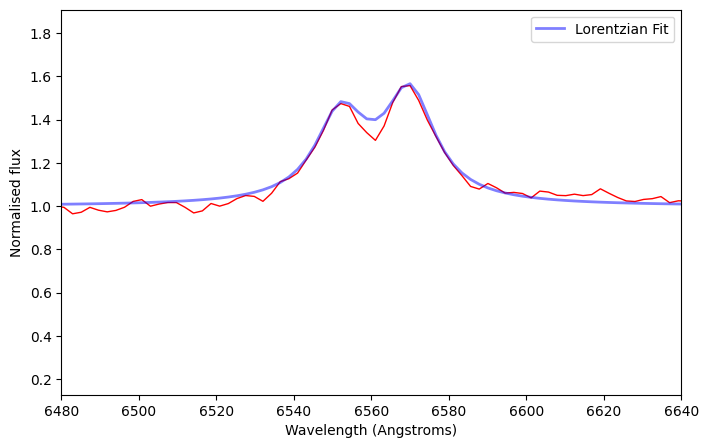

In [10]:
########### Lorentzian fitting and plot:
guess = [6555, 1.4, 6.0, 6561.0, -1.1, 3.0, 6565.0, 1.6, 4.0]
guess = find_double_peak_coords(spec.spectral_axis.value,(spec.flux/y_cont_fitted).value)
print(guess)
    #for i in range(1):
#guess += [60+80*i, 46000, 25]


popt, pcov = curve_fit(func_lorentzian, (spec.spectral_axis).value, (spec.flux/y_cont_fitted).value, p0=guess)
print(popt)
fit_LORERTZIAN = func_lorentzian(spec.spectral_axis.value, *guess)

fig=plt.figure(figsize=(graph_W,graph_H)) #create the figure
# plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalised flux')
plt.xlim(xmin,xmax)
plt.plot(spec.spectral_axis.value, (spec.flux/y_cont_fitted).value, 'r-', linewidth=1)
plt.plot(spec.spectral_axis.value, fit_LORERTZIAN , 'b-', linewidth=2, alpha=0.5, label='Lorentzian Fit')
plt.legend()
#plt.show()
plt.savefig('Lorentzian_demo.png')
###########

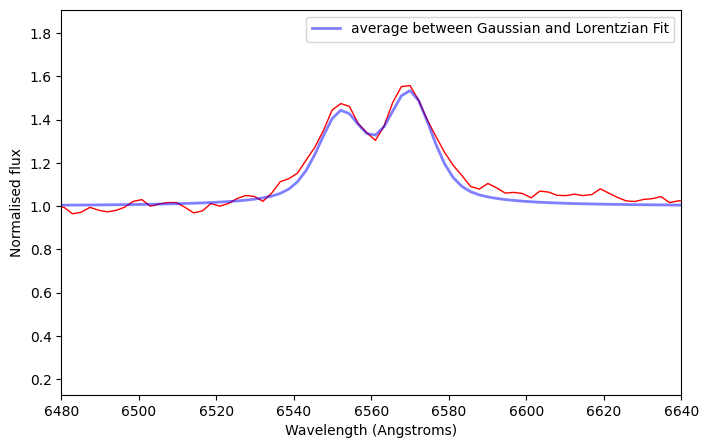

In [13]:
########### Agerage between GAUS and LORERNTZ fits, fitting and plot:

fit_AVG=(fit_GAUS+fit_LORERTZIAN)/2

fig=plt.figure(figsize=(graph_W,graph_H)) #create the figure
# plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalised flux')
plt.xlim(xmin,xmax)
plt.plot(spec.spectral_axis.value, (spec.flux/y_cont_fitted).value, 'r-', linewidth=1)
plt.plot(spec.spectral_axis.value, fit_AVG , 'b-', linewidth=2, alpha=0.5,label='average between Gaussian and Lorentzian Fit')
plt.legend()
#plt.show()
plt.savefig('Average_GAUS_LORENTZ_demo.png')
###########

[6.55088892e+03 7.50847603e+00 4.41224158e+00 6.57004009e+03
 1.15460265e+01 5.33661883e+00]


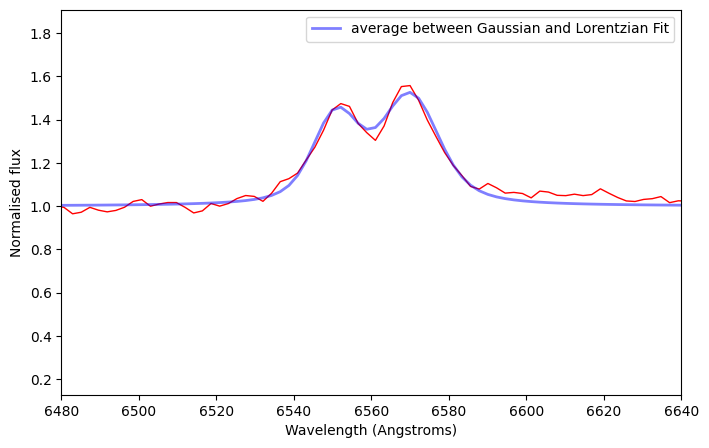

In [ ]:
########### Voigt fitting and plot:

guess = [6555, 1.4, 6.0, 6.0, 6565.0, 1.5, 4.0, 4.0]
guess = find_double_peak_coords(spec.spectral_axis.value,(spec.flux/y_cont_fitted).value)
    #for i in range(1):
#guess += [60+80*i, 46000, 25]

popt, pcov = curve_fit(func_voigt, (spec.spectral_axis).value, (spec.flux/y_cont_fitted).value, p0=guess)
print(popt)
fit_VOIGT = func_voigt(spec.spectral_axis.value, *popt)
# fit_VOIGT=np.convolve(fit_GAUS,fit_LORERTZIAN,mode='same')

fig=plt.figure(figsize=(graph_W,graph_H)) #create the figure
# plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalised flux')
plt.xlim(xmin,xmax)
plt.plot(spec.spectral_axis.value, (spec.flux/y_cont_fitted).value, 'r-', linewidth=1)
plt.plot(spec.spectral_axis.value, fit_VOIGT , 'b-', linewidth=2, alpha=0.5,label='Voigt Fit')
plt.legend()
#plt.show()
plt.savefig('Voigt_demo.png')
###########

[99.63686354 29.57537609  2.79050398  3.90880365 73.9226584  70.74399566
  3.18382538  2.96960336]


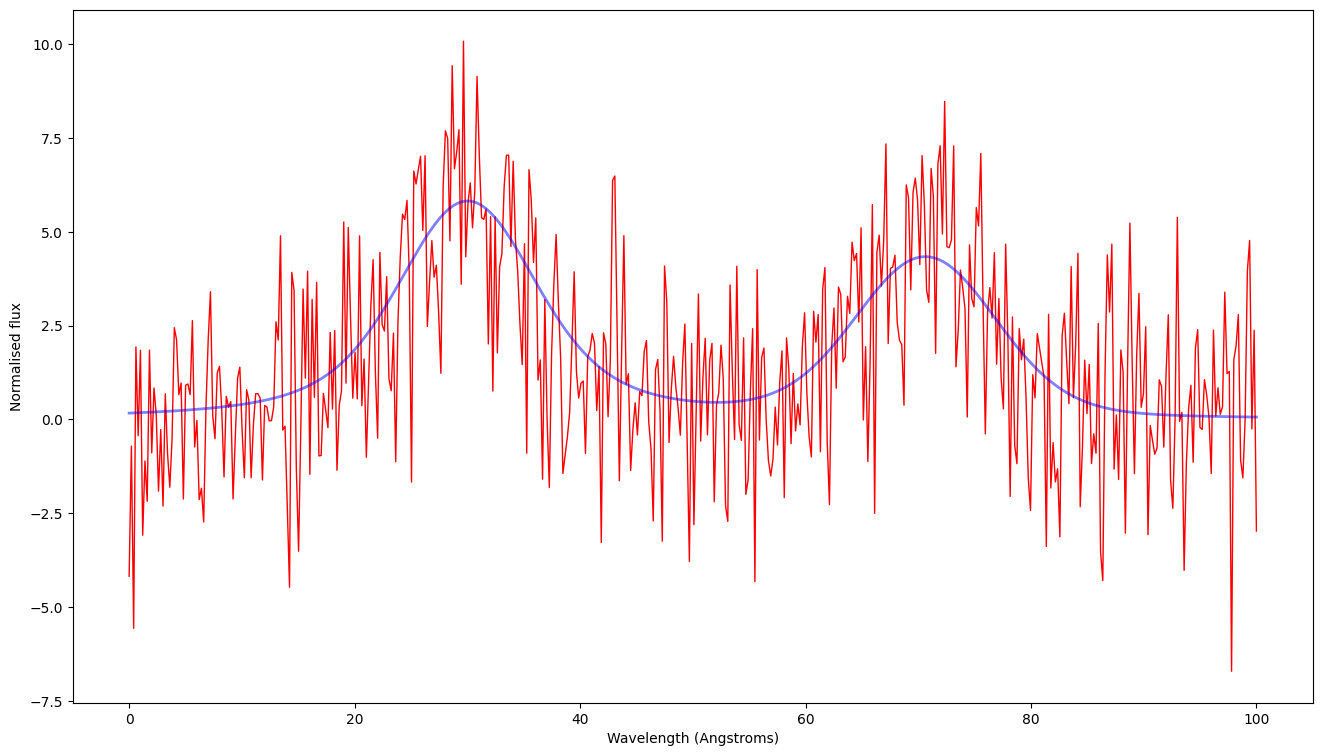

In [ ]:
import numpy as np
from scipy.optimize import curve_fit


def double_voigt(x, amp1, cen1, sig1, gam1, amp2, cen2, sig2, gam2):
    """
    A function representing the sum of two Voigt profiles.
    Parameters:
        x (array_like): The independent variable (e.g., wavelength, energy).
        amp1, cen1, sig1, gam1 (float): Parameters for the first Voigt profile.
        amp2, cen2, sig2, gam2 (float): Parameters for the second Voigt profile.
    Returns:
        array_like: The sum of two Voigt profiles at given x values.
    """
    return voigt_profile(x - cen1, sig1, gam1) * amp1 + \
           voigt_profile(x - cen2, sig2, gam2) * amp2

# Example usage with dummy data
# Replace with your actual x_data and y_data
x_data = np.linspace(0, 100, 500)
# Create some noisy double-peaked data for demonstration
y_data = (voigt_profile(x_data - 30, 5, 2) * 100 +
          voigt_profile(x_data - 70, 4, 3) * 70 +
          np.random.normal(0, 2, len(x_data)))

# Initial guesses for the 8 parameters
# (amp1, cen1, sig1, gam1, amp2, cen2, sig2, gam2)
initial_guesses = [90, 30, 5, 2, 60, 70, 4, 3]


popt, pcov = curve_fit(double_voigt, x_data, y_data, p0=initial_guesses)
print(popt)

fit = double_voigt(x_data, 113.90545215,  30.02391812,   4.34510307,   3.86406725,  71.52031152,  70.67003695,   5.77831164 ,  1.13183806)

fig=plt.figure(figsize=(16, 9)) #create the figure
# plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalised flux')
# plt.xlim(6520,6600)
plt.plot(x_data, y_data, 'r-', linewidth=1)
plt.plot(x_data, fit , 'b-', linewidth=2, alpha=0.5)
plt.show()

In [ ]:
# Areas python script:
from scipy.integrate import quad
import numpy as np
import pylab as pl
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#This script calculates the blue and red surface areas and these are compared with the measured equivalent widths
#Equations A.17 and A.18

file = np.loadtxt('HR_ave_velocities.dat')
file2 = np.loadtxt('HR_ave_EW.dat')


MJD = file[:,0]
#cycles = file[:,1]
v_blue = file[:,2]
v_red = file[:,3]

EW_blue = file2[:,2]
EW_red = file2[:,3]

MJD_eph = 43366.275


def integrand(x,eccen):
    return 1.0/((1.0 + eccen*np.cos(x))**2)

ep = 0.4

#print I[0]

a_in = 1.0/(1.0 - ep)
inc = 0.52
v_crit = 525.0
degtorad = np.pi/180.0
radtodeg = 180.0/np.pi

g = open("HR_Areas_ave_out.txt","w")
for i in range(len(MJD)):
    t1 = ((2.0*v_crit)/(v_red[i] - v_blue[i]))**2
    t2 = ((np.sin(inc))**2)/(1.0 - ep**2)
    a_p = t1*t2
    ts1 = 0.5*(a_p**2 - a_in**2)*(1.0 - ep**2)*np.cos(inc)
    MJD_conv = MJD[i] - 2400000.5
    ratio = ((v_red[i]+v_blue[i])/(v_red[i]-v_blue[i]))
    om = np.arccos(ratio*(1.0/ep))
    cos_om = ratio*(1.0/ep)
    f01 = np.arccos(-ep*cos_om) - om
    f01_deg = f01*radtodeg
    
    f02 = (2.0*np.pi - np.arccos(-ep*cos_om)) - om
    f02_deg = f02*radtodeg
    
    
    I_b = quad(integrand,f01,f02,args=(ep))
    ts2 = I_b[0]
    S_blue = ts1*ts2
    I_r = quad(integrand,f02,f01+2.0*np.pi,args=(ep))
    ts3 = I_r[0]
    S_red = ts1*ts3
    ratio_areas = S_blue/S_red
    ratio_EW = EW_blue[i]/EW_red[i]
    g.write("%0.3f  %0.3f   %0.3f   %0.3f   %0.3f   %0.3f   %0.3f   %0.3f   %0.3f   %0.3f   %0.3f\n" %(MJD[i],S_blue,S_red,EW_blue[i],EW_red[i],ratio_areas,ratio_EW,I_b[0],I_r[0],f01_deg,f02_deg))
g.close()




In [33]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def map_DEG_to_RA(deg_list):
    RA_list=[]
    coord=0
    for i in range(0,len(deg_list)):
        hour= (deg_list[i]//1)*(1/15) #get the integer part of the float degree value and convert to hours. (1/15 hours per degree)
        minute= (hour-hour//1)*4.0 #decimal part of the degree float converted to minutes (4 minutes per degree)
        second= (minute-minute//1)*60 #decimal part of the minute coordinate, converted to seconds coordinate (60 sec per minute)
        coord=hour//1+(minute//1)/100+((second//1)//1)/10000
        RA_list.append(coord)
    return(RA_list)

print(map_DEG_to_RA([22.2565,23]))

[1.0151000000000001, 1.0207]


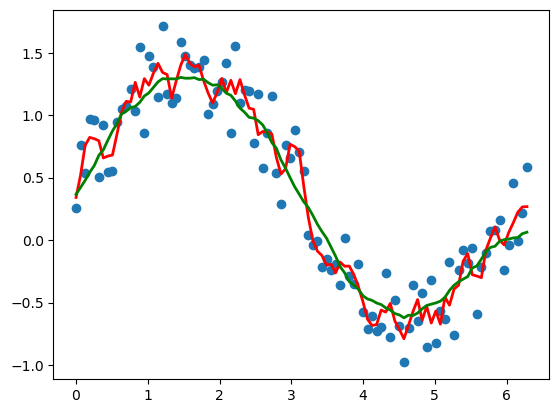

In [11]:
#Smoothing code
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.8

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.plot(x, y,'o')
# plt.show()
# plt.close()
plt.plot(x, smooth(y,3), 'r-', lw=2)
# plt.show()
# plt.close()
plt.plot(x, smooth(y,19), 'g-', lw=2)
plt.show()
plt.close()

In [136]:
def Plot_Cont_Norm_Pic(PName):
    with open('uvi_data.csv') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
    #         print(row)
            dat=fits.open(str(row[0]))
            if(str(row[0])==PName):

                #sort the names and spectral types using delimiter
                name=row[0][0:-5]
                SpecT=row[1]

                #Get the header info and curve data
                hdr = dat[0].header
                data=dat[1].data
                s1=[]

                wav=[]
                for i in range(540,1655):#(540,1655)
                    s1.append(data[i][1])
                    wav.append(data[i][0])
    #                     print(i,data[i][0])
    #                 print(s1)

                #Continuum fitting 
                    #get objects in 'Quantity' format
                s1_cal=s1*u.Unit('erg cm-2 s-2 AA-1')
                print("s1_cal:",s1_cal)
                crval1 = s1_cal[0]
                cd11 = s1_cal[1]-s1_cal[0]
                wav_cal = wav*u.AA

                spec=Spectrum1D(spectral_axis=wav_cal,flux=s1_cal)
#                 print(spec)
                s_fit=fgc(spec,median_window=109)
                y_cont_fitted=s_fit(wav_cal)
                #Testing fitted continuum:
#                 print("cont_fitted",y_cont_fitted)
#                 fig=plt.figure(figsize=(16, 9)) #create the figure
#                 plt.yscale("log") #set y scale to log to correctly display the spectra
#                 plt.plot(spec.spectral_axis, spec.flux, label='spectra')
#                 plt.plot(wav_cal, y_cont_fitted, label='fitted continuum')
#                 plt.legend()
#                 plt.show()
#                 plt.close()

                #plotting
                s1max=max(s1)
                for i in range(0,len(s1)):
                    s1[i]=s1_cal[i]/y_cont_fitted[i]

#                 plt.yscale("log")
#                 plt.xlim(3968.6,7500)
                plt.plot(wav, s1, label="Pickles type "+str(SpecT), linewidth=0.5, color="teal")
        #         break
    f.close()

def Plot_Cont_Norm_MrKT(PName):
    f_c = open("My_cal_files.csv", "r")
    files_cali=[]
    line=f_c.readline()
    while line!='':
        row_data = line.strip("\n").split(',') # split the csv data columns
        files_cali.append(row_data[0]) #add the name of the file into the file names list
        line=f_c.readline() #read the next line
    #     print(line)
    f_c.close()

    dat_cal=fits.open(PName)
    name=PName
    print(name)

    hdr_cal=dat_cal[0].header
    data_cal=dat_cal[0].data

    s1_cal=data_cal[0,0]*u.Unit('erg cm-2 s-2 AA-1') #flux data
    n_s1_cal=s1_cal/max(s1_cal) #normalised flux

    crval1 = hdr_cal['CRVAL1']
    cd11 = hdr_cal['CD1_1']
    wav_cal = (crval1 +np.arange(len(s1_cal))*cd11)*u.AA #wavelength data


    spec=Spectrum1D(spectral_axis=wav_cal[0:1300],flux=s1_cal[0:1300])
    print(spec)
    s_fit=fgc(spec,median_window=109)
    y_cont_fitted=s_fit(wav_cal[0:1300])
    s1=[]

    for i in range(0,len(spec.flux)):
        s1.append(s1_cal[i]/y_cont_fitted[i])


#     fig=plt.figure(figsize=(16, 9)) #create the figure
#     plt.yscale("log")
    plt.plot(wav_cal[0:1300], s1, label="Target", linewidth=0.5, color="red")
    plt.legend()

